<a href="https://colab.research.google.com/github/BalintKomjati/infinite-loop/blob/main/stable-diffusion-2-infinite-zoom-out/infinite_zoom_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@markdown CHECK TYPE OF GPU AND VRAM AVAILABLE   <br>
#@markdown The notebook should work with the Tesla T4 GPU + 16 GB VRAM available in the free colab tier.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15360 MiB, 15109 MiB


In [2]:
#@markdown INSTALL MISSING LIBRARIES
%pip install -qq transformers scipy ftfy accelerate
%pip install -qq --upgrade diffusers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 KB 26.1 MB/s eta 0:00:00


In [3]:
#@markdown LOAD LIBRARIES
import PIL
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import random
import cv2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from IPython.display import clear_output

In [4]:
#@markdown DEFINE HELPER FUNCTIONS
def write_video(file_path, frames, fps, reversed = True):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    :param reversed: if order of images to be reversed (default = True)
    """
    if reversed == True:
      frames.reverse()

    w, h = frames[0].size
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    #fourcc = cv2.VideoWriter_fourcc(*'avc1')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (w, h))

    for frame in frames:
        np_frame = np.array(frame.convert('RGB'))
        cv_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
        writer.write(cv_frame)

    writer.release() 

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

def shrink_and_paste_on_blank(current_image, STEPSIZE):

  height = current_image.height
  width = current_image.width

  #shrink down by STEPSIZE
  prev_image = current_image.resize((height-2*STEPSIZE,width-2*STEPSIZE))
  prev_image = prev_image.convert("RGBA")
  prev_image = np.array(prev_image)

  #create blank non-transparent image
  blank_image = np.array(current_image.convert("RGBA"))*0
  blank_image[:,:,3] = 1

  #paste shrinked onto blank
  blank_image[STEPSIZE:height-STEPSIZE,STEPSIZE:width-STEPSIZE,:] = prev_image
  prev_image = Image.fromarray(blank_image)

  return prev_image

In [5]:
#@markdown DOWNLOAD STABLE DIFFUSION OUTPAINTING MODEL AND SET UP DIFFUSION PIPELINE
model_id = "stabilityai/stable-diffusion-2-inpainting" #@param
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16")
#pipe.set_use_memory_efficient_attention_xformers(True) #https://huggingface.co/docs/diffusers/optimization/fp16#memory-efficient-attention #couldnt make it run on colab
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
def dummy(images, **kwargs):
    return images, False
pipe.safety_checker = dummy
pipe.enable_attention_slicing() #This is useful to save some memory in exchange for a small speed decrease.

g_cuda = torch.Generator(device='cuda')

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

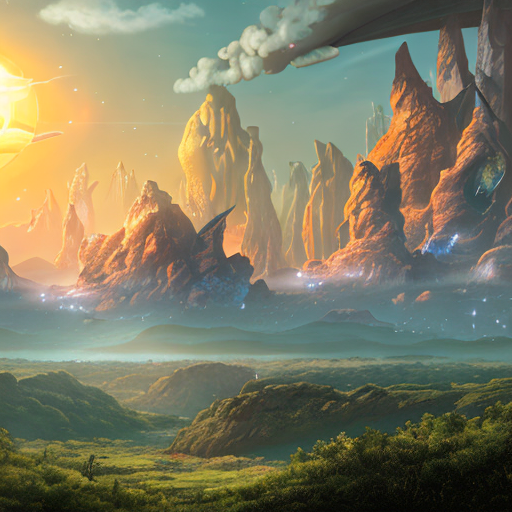

In [52]:
#@markdown FIND A GOOD CONCEPT: <br>
#@markdown (Output of this block will be the last image of the video)

orig_prompt = "A dream of a distant galaxy, concept art, matte painting, HQ, 4k" #@param
orig_negative_prompt = "blur, blurred, frame, ugly, low quality" #@param

num_images = 1 #@param
seed = 101011 #@param
num_inference_steps = 20 #@param
guidance_scale = 8 #@param
height = 512 #@param
width = height #@param


prompt = [orig_prompt] * num_images
negative_prompt = [orig_negative_prompt] * num_images

current_image = PIL.Image.new(mode="RGBA", size=(height, width))
mask_image = np.array(current_image)[:,:,3] 
mask_image = Image.fromarray(255-mask_image).convert("RGB")
current_image = current_image.convert("RGB")

init_images =  pipe(prompt=prompt,
                    negative_prompt=negative_prompt,
                    image=current_image,
                    guidance_scale = guidance_scale,
                    height = height,
                    width = width, 
                    generator = g_cuda.manual_seed(seed),
                    mask_image=mask_image, 
                    num_inference_steps=num_inference_steps)[0]


image_grid(init_images, rows=1, cols=num_images)

In [ ]:
#@markdown GENERATE VIDEO:  <br> <br>
#@markdown Pick an image from the previous block for your video: <br> (0 = 1st image. This is only relevant if num_images > 1)
image_num_selected = 0 #@param
#@markdown Number of outpainting steps:
NUMFRAMES = 5 #@param
#@markdown Width of the border in pixels to be outpainted during each step:
#@markdown <br> (2*STEPSIZE < height & width)
STEPSIZE = 128 #@param
#@markdown Number of frames to be interpolated between each outpainting step
num_interpol_frames = 24 #@param 
#@markdown Note: length of the video ~ NUMFRAMES * NUMOFINTERPOLFRAMES

#ideally STEPSIZE should be a power of 2
#ideally STEPSIZE / (num_interpol_frames) / 2 should be even

current_image = init_images[0]
all_frames = []
all_frames.append(current_image)

for i in range(NUMFRAMES):
  print('Generating image: ' + str(i+1) + ' / ' + str(NUMFRAMES))

  prev_image_fix = current_image

  prev_image = shrink_and_paste_on_blank(current_image, STEPSIZE)

  current_image = prev_image

  #create mask (black image with white STEPSIZE width edges)
  mask_image = np.array(current_image)[:,:,3] 
  mask_image = Image.fromarray(255-mask_image).convert("RGB")

  #inpaint
  current_image = current_image.convert("RGB")
  images = pipe(prompt=prompt,
                negative_prompt=negative_prompt,
                image=current_image,
                guidance_scale = guidance_scale,
                height = height,
                width = width, 
                #generator = g_cuda.manual_seed(seed), #this makes the whole thing deterministic but the output less exciting
                mask_image=mask_image, 
                num_inference_steps=num_inference_steps)[0]
  current_image = images[0]
  current_image.paste(prev_image, mask=prev_image)

  #zoom and crop to create interpolated frames between 2 inpainted frames
  for j in range(num_interpol_frames - 1):
    interpol_image = current_image
    pix = round(
        (1- ( 1-2*STEPSIZE/height )**( 1-(j+1)/num_interpol_frames ) )*height/2 
        )
    interpol_image = interpol_image.crop((pix,
                                          pix,
                                          width - pix,
                                          height - pix))

    interpol_image = interpol_image.resize((height, width))

    #fix blur in the middle:
    pix2 = round((height - (height - 2*STEPSIZE)*height/(height-2*pix))/2)
    prev_image_fix_crop = shrink_and_paste_on_blank(prev_image_fix, pix2)
    interpol_image.paste(prev_image_fix_crop, mask = prev_image_fix_crop)

    all_frames.append(interpol_image)

  all_frames.append(current_image)
  clear_output(wait=True)

In [54]:
#@markdown RENDER THE GENERATED FRAMES INTO AN MP4 VIDEO.
video_file_name = "infinite_zoom_out" #@param
write_video(video_file_name + ".mp4", all_frames, 24)
#@markdown Once finished download your video from the "Files" folder menu on the left.

In [ ]:
#@markdown CHECK SOME (equally spaced) FRAMES OF THE VIDEO:
num_of_frames_to_chk = 4 #@param
num_of_frames_to_chk = min(num_of_frames_to_chk, len(all_frames))
idx = np.round(np.linspace(0, len(all_frames) - 1, num_of_frames_to_chk)).astype(int)
image_grid(list(all_frames[i] for i in idx), rows = 1, cols = num_of_frames_to_chk)
#@markdown (This is relatively slow but still faster in some cases then to download the complete video in the previous block)


TODO

 - Refactor: "fix blur in the middle" == 1st steps in the outer loop
 - Tweak prompts (drift between prompts)
 - noncubic resolutions res


In [ ]:
#frame_one = all_frames[0]
#frame_one.save("all_frames.gif", format="GIF", append_images=all_frames[1:], save_all=True, duration=250, loop=0)